# Tetrad Crop Tutorial: Yeast Colony Image Processing Pipeline

This tutorial walks through the image processing pipeline for yeast colony detection and plate cropping using OpenCV. The pipeline is designed for DIT-HAP verification experiments with yeast microscopy images.

## Overview of the Pipeline

1. **Circle Detection**: Identify circular plates in images using Hough circle transform
2. **Plate Cropping**: Crop to detected circular regions
3. **Preprocessing**: Enhance contrast and remove background
4. **Binarization**: Convert to binary image using adaptive thresholding
5. **Colony Detection**: Identify individual colonies using watershed segmentation
6. **Centroid Calculation**: Determine plate centroid for final cropping
7. **Final Cropping**: Create standardized cropped output

In [120]:
# %% ------------------------------------ Imports ------------------------------------ #
import sys
from pathlib import Path
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path().absolute().parent / "src"))

# Core libraries
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import ndimage

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")
print(f"OpenCV version: {cv2.__version__}")

Libraries imported successfully!
OpenCV version: 4.12.0


## Configuration Parameters

The image processing pipeline uses a configuration class to manage all parameters. Let's define and explain these parameters:

In [121]:
# %% ------------------------------------ Constants ------------------------------------ #
REPLICA_PLATES_ORDER = {
    0: "YES",
    1: "HYG", 
    2: "NAT",
    3: "LEU",
    4: "ADE"
}

REPLICA_NAME = "YHZAY2A"

# %% ------------------------------------ Dataclass ------------------------------------ #
@dataclass
class ImageProcessingConfig:
    """Configuration for image processing."""
    
    # Plate parameters
    target_radius: int = 512  # Plate radius in pixels
    
    # Plate narrowing parameters (percentage of plate to process)
    height_range: tuple[int, int] = (45, 85)
    width_range: tuple[int, int] = (5, 95)
    
    # Binary processing parameters
    adaptive_thresh_c: int = 2
    normal_centroid_deviation_px: int = 15
    max_centroid_deviation_px: int | None = 100
    min_colony_size: int = 50  # Minimum colony size in pixels
    circularity_threshold: float = 0.7  # Circularity threshold for colony detection
    solidity_threshold: float = 0.9  # Solidity threshold for colony detection
    adaptive_block_size: int = 30  # Must be odd number
    contrast_alpha: float = 1.0  # Contrast adjustment factor
    
    # Final cropping parameters
    final_height: int = 300
    final_width: int = 750
    visualize_colonies: bool = True

# Create configuration instances
tetrad_config = ImageProcessingConfig(
    min_colony_size=50,
    circularity_threshold=0.7,
    solidity_threshold=0.9,
    adaptive_block_size=30,
    contrast_alpha=1.0
)

replica_config = ImageProcessingConfig(
    min_colony_size=500,
    circularity_threshold=0.45,
    solidity_threshold=0.7,
    adaptive_block_size=200,
    contrast_alpha=1.6
)

print("Configuration created:")
print(f"Tetrad config: min_colony_size={tetrad_config.min_colony_size}, circularity={tetrad_config.circularity_threshold}")
print(f"Replica config: min_colony_size={replica_config.min_colony_size}, circularity={replica_config.circularity_threshold}")

Configuration created:
Tetrad config: min_colony_size=50, circularity=0.7
Replica config: min_colony_size=500, circularity=0.45


## Helper Functions for Visualization

Let's create some helper functions to visualize the processing steps:

In [122]:
def show_images(images: list, titles: list = None, cmap: str = 'gray', figsize: tuple = (15, 5)):
    """Display multiple images side by side."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    for i, img in enumerate(images):
        if len(img.shape) == 3:
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            axes[i].imshow(img, cmap=cmap)
        
        if titles and i < len(titles):
            axes[i].set_title(titles[i], fontsize=12)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def overlay_circles(image: np.ndarray, circles: np.ndarray, color: tuple = (0, 255, 0), thickness: int = 2):
    """Overlay detected circles on image."""
    if circles is None:
        return image
    
    overlay = image.copy()
    if len(overlay.shape) == 2:
        overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)
    
    for circle in circles:
        x, y, r = circle.astype(int)
        cv2.circle(overlay, (x, y), r, color, thickness)
        cv2.circle(overlay, (x, y), 5, color, -1)
    
    return overlay

print("Visualization helper functions defined!")

Visualization helper functions defined!


In [123]:
data_folder = Path("/hugedata/YushengYang/DIT_HAP_verification/data/processed_data/DIT_HAP_deletion")

# all_images = list(data_folder.glob("*/replica/*.tif"))
all_images = list(data_folder.glob("*/*d/*.tif"))

## Step 1: Circle Detection

The first step is to detect circular plates in the image using Hough circle transform. This is essential for identifying the region of interest and cropping to the plates.

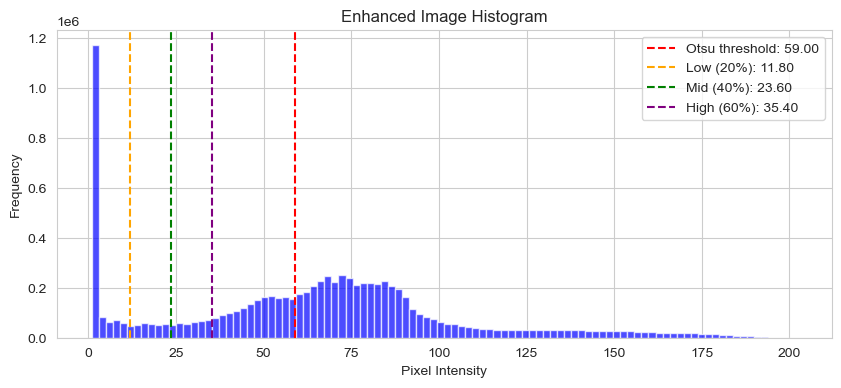

✓ Circles detected using: Canny edges with standard params


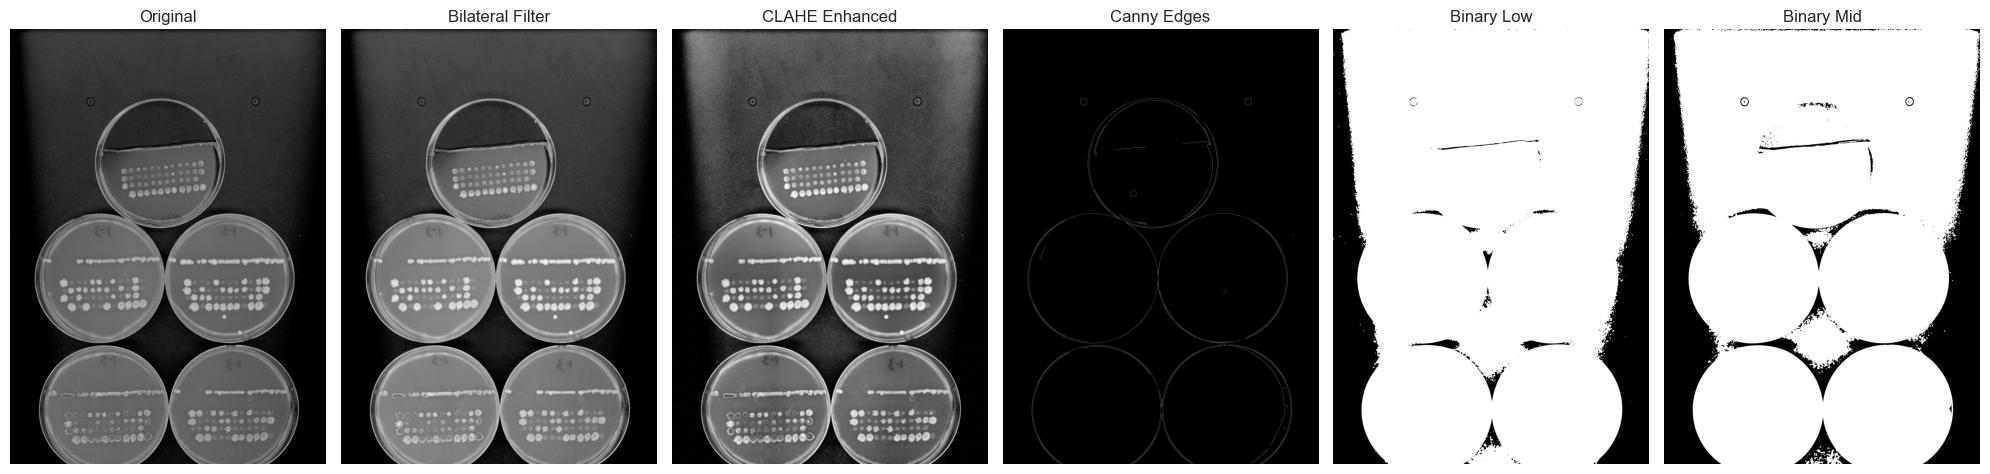

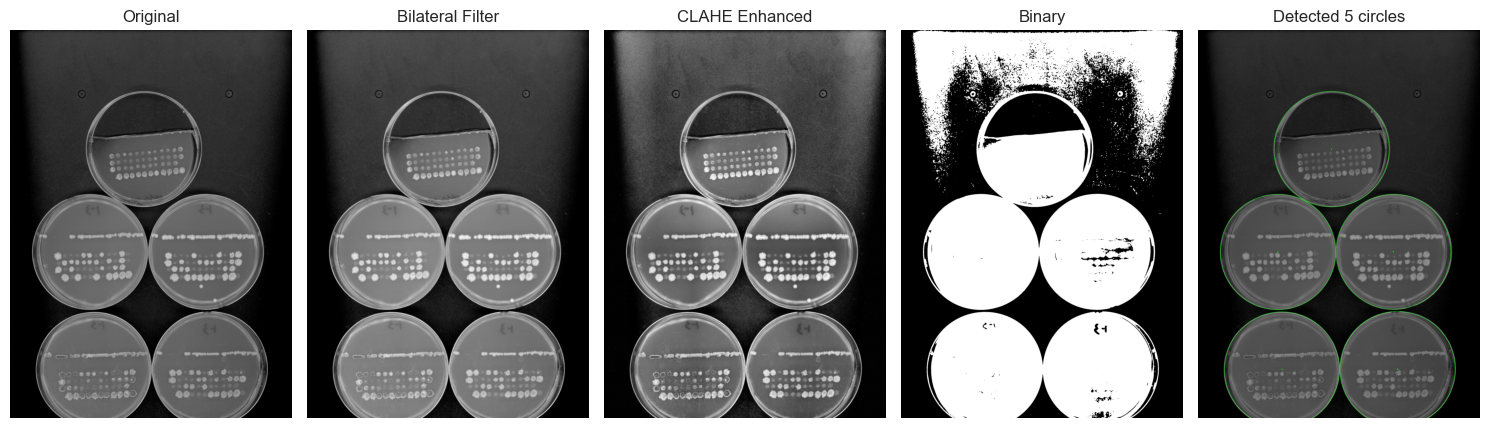

Found 5 circles
  Circle 1: center=(1206.5, 1083.5), radius=522.7
  Circle 2: center=(1766.5, 2009.5), radius=519.0
  Circle 3: center=(722.5, 2011.5), radius=522.9
  Circle 4: center=(760.5, 3070.5), radius=520.7
  Circle 5: center=(1803.5, 3067.5), radius=521.8


In [124]:
def find_circle_plates(
    image: str | Path | np.ndarray,
    target_radius: int = 515,
    min_dist: float = 500,
    param1: int = 100,
    param2: int = 50,
    dp: float = 1,
    visualize: bool = True
) -> np.ndarray | None:
    """Find circular plate images using Hough circle detection."""
    if isinstance(image, (str, Path)):
        img = cv2.imread(str(image), cv2.IMREAD_GRAYSCALE)
    else:
        img = image if len(image.shape) != 3 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if img is None:
        raise ValueError(f"Could not read image: {image}")

    # Preprocessing for circle detection - try multiple approaches
    blurred = cv2.bilateralFilter(img, 9, 75, 75)  # Edge-preserving blur
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    
    # Try edge detection (often works better for Hough circles)
    edges = cv2.Canny(blurred, 30, 100)
    
    # Create multiple binary versions with different thresholds
    otsu_thresh, binary_otsu = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_low = np.where(enhanced >= 0.2*otsu_thresh, 255, 0).astype(np.uint8)
    binary_mid = np.where(enhanced >= 0.4*otsu_thresh, 255, 0).astype(np.uint8)
    binary_high = np.where(enhanced >= 0.6*otsu_thresh, 255, 0).astype(np.uint8)
    
    # Show enhanced histogram for analysis
    if visualize:
        plt.figure(figsize=(10, 4))
        plt.hist(enhanced.flatten(), bins=100, alpha=0.7, color='blue')
        plt.axvline(otsu_thresh, color='r', linestyle='--', label=f'Otsu threshold: {otsu_thresh:.2f}')
        plt.axvline(0.2*otsu_thresh, color='orange', linestyle='--', label=f'Low (20%): {0.2*otsu_thresh:.2f}')
        plt.axvline(0.4*otsu_thresh, color='green', linestyle='--', label=f'Mid (40%): {0.4*otsu_thresh:.2f}')
        plt.axvline(0.6*otsu_thresh, color='purple', linestyle='--', label=f'High (60%): {0.6*otsu_thresh:.2f}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.title('Enhanced Image Histogram')
        plt.legend()
        plt.show()
        plt.close()

    # Define radius range (more flexible)
    min_radius = target_radius - 25
    max_radius = target_radius + 25
    
    # Try multiple detection strategies
    detection_strategies = [
        # (image, dp, param1, param2, description)
        (edges, 1, 50, 30, "Canny edges with standard params"),
        (binary_low, 1, 100, 50, "Low threshold binary"),
        (binary_mid, 1, 100, 50, "Mid threshold binary"),
        (enhanced, 1, 100, 50, "CLAHE enhanced"),
        (edges, 1.2, 40, 25, "Canny edges relaxed"),
        (binary_high, 1, 80, 40, "High threshold binary"),
        (enhanced, 1.5, 80, 40, "Enhanced with larger dp"),
        (blurred, 1, 100, 50, "Blurred only"),
        (edges, 1, 30, 20, "Canny very relaxed"),
        (binary_otsu, 1, 100, 50, "Otsu binary"),
    ]
    
    circles = None
    successful_strategy = None
    
    for strategy_img, dp_val, p1, p2, description in detection_strategies:
        circles = cv2.HoughCircles(
            strategy_img, cv2.HOUGH_GRADIENT,
            dp=dp_val, minDist=min_dist,
            param1=p1, param2=p2,
            minRadius=min_radius, maxRadius=max_radius
        )
        if circles is not None:
            successful_strategy = description
            if visualize:
                print(f"✓ Circles detected using: {description}")
            break
    
    if visualize:
        show_images(
            [img, blurred, enhanced, edges, binary_low, binary_mid],
            ['Original', 'Bilateral Filter', 'CLAHE Enhanced', 'Canny Edges', 'Binary Low', 'Binary Mid'],
            figsize=(20, 8)
        )
    
    if circles is not None:
        circles = circles[0]
        if visualize:
            # Show the detection process
            show_images(
                [img, blurred, enhanced, binary_otsu, overlay_circles(img, circles)],
                ['Original', 'Bilateral Filter', 'CLAHE Enhanced', 'Binary', f'Detected {len(circles)} circles']
            )
        return circles
    else:
        if visualize:
            print(f"No circles detected in image")
        return None

# Test with a sample image (you'll need to provide an actual image path)

sample_image_path = "/hugedata/YushengYang/DIT_HAP_verification/data/processed_data/DIT_HAP_deletion/1st_round/replica/1_rpl14_YHZAY2A_#3_202411.tif"
# sample_image_path = "/hugedata/YushengYang/DIT_HAP_verification/data/processed_data/DIT_HAP_deletion/1st_round/replica/1_rpl14_YHZAY2A_#3_202411.tif"
# sample_image_path = str(all_images[np.random.randint(0, len(all_images))])
if Path(sample_image_path).exists():
    circles = find_circle_plates(sample_image_path, target_radius=515, visualize=True)
    if circles is not None:
        print(f"Found {len(circles)} circles")
        for i, circle in enumerate(circles):
            print(f"  Circle {i+1}: center=({circle[0]:.1f}, {circle[1]:.1f}), radius={circle[2]:.1f}")
else:
    print("Sample image not found. Please update the path.")

## Step 2: Plate Cropping

Once circles are detected, we crop the image to the circular regions. This gives us individual plate images for processing.

[(1, 2), (2, 3), (2, 1), (3, 1), (3, 3)]
Processing replica image


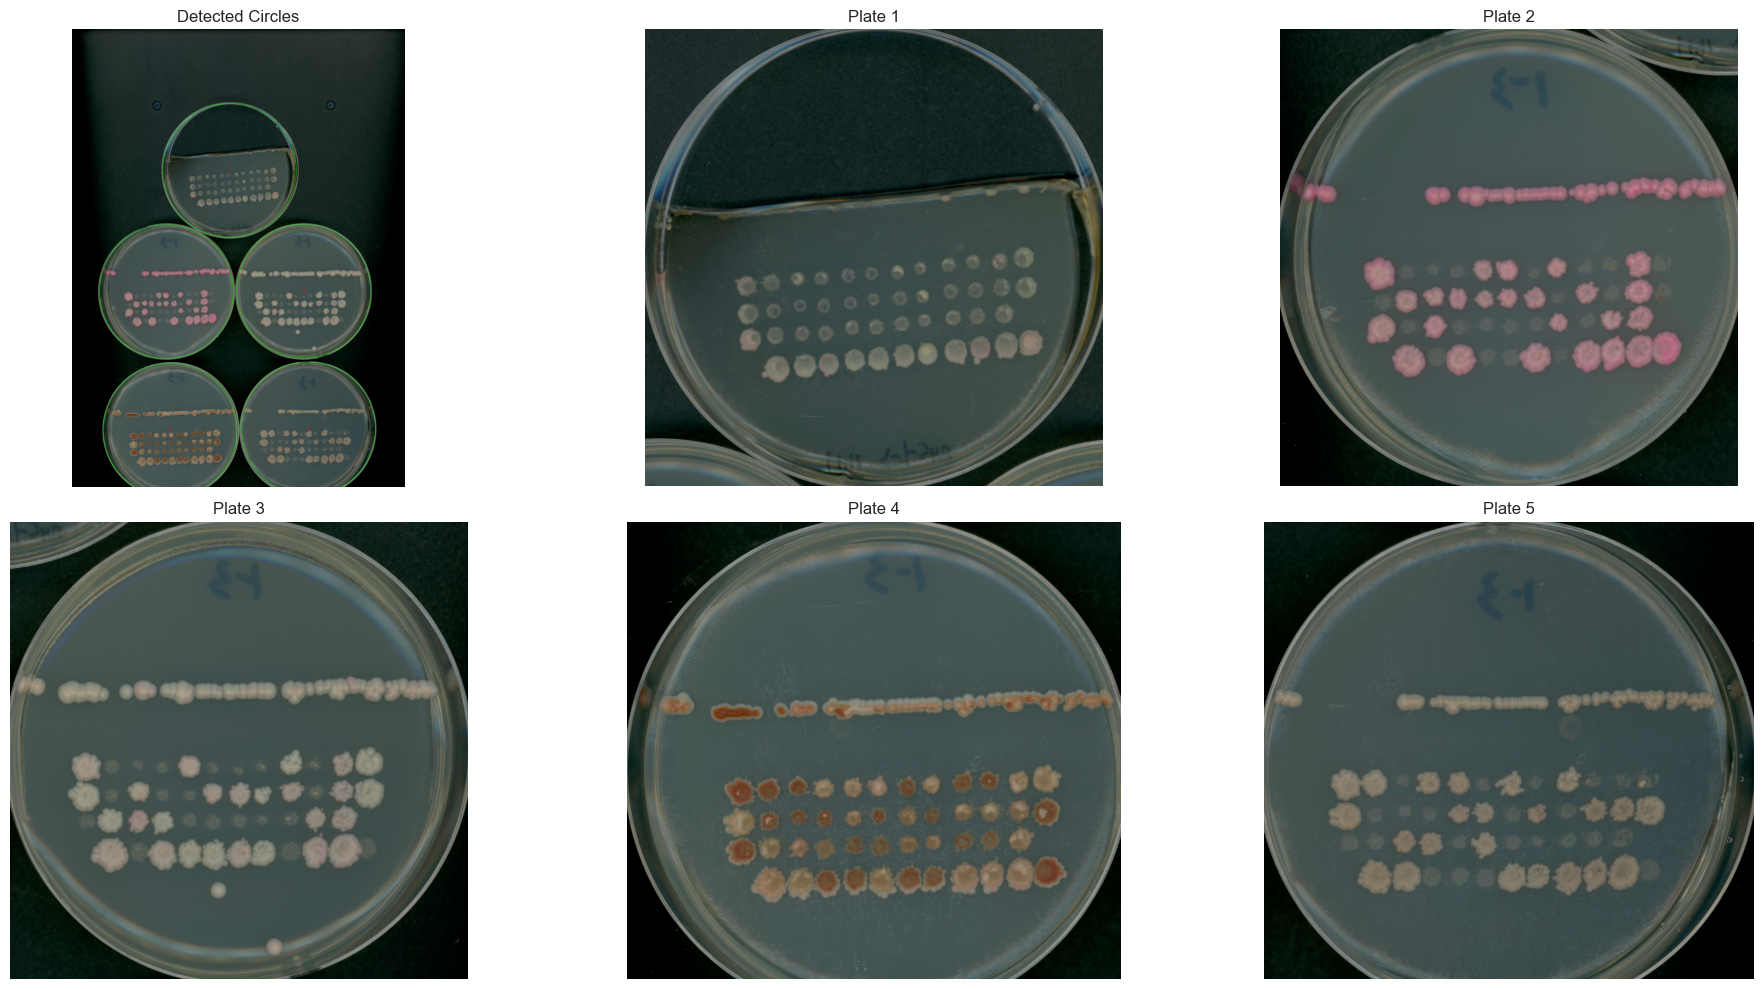

Successfully cropped 5 plates
  Plate 1: (1024, 1024, 3)
  Plate 2: (1024, 1024, 3)
  Plate 3: (1024, 1024, 3)
  Plate 4: (948, 1024, 3)
  Plate 5: (957, 1024, 3)


In [125]:
def crop_to_circle(
    image: Path,
    radius: int,
    visualize: bool = True
) -> list[np.ndarray]:
    """Crop the image to circular regions defined by detected circles."""
    img = cv2.imread(str(image), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image: {image}")
    
    # Find circles
    circles = find_circle_plates(img, target_radius=radius, visualize=False)
    
    if circles is None:
        raise ValueError(f"No circle detected in image: {image}")
    
    plates = []
    
    # Sort circles by position (left to right, top to bottom)
    sorted_keys = [(int(round(c[1]/1000)), int(round(c[0]/600))) for c in circles]
    print(sorted_keys)
    sorted_circles = sorted(circles, key=lambda c: (int(round(c[1]/1000)), int(round(c[0]/600))))
    
    # Check if this is a replica plate (multiple plates in one image)
    is_replica = REPLICA_NAME in image.stem
    
    if visualize:
        print(f"Processing {'replica' if is_replica else 'tetrad'} image")
        if is_replica and len(sorted_circles) != 5:
            print(f"Warning: Expected 5 replica plates, found {len(sorted_circles)}")
    
    # Crop each detected circle
    for i, c in enumerate(sorted_circles):
        x, y = int(c[0]), int(c[1])
        x1, x2 = max(0, x - radius), min(img.shape[1], x + radius)
        y1, y2 = max(0, y - radius), min(img.shape[0], y + radius)
        plate = img[y1:y2, x1:x2]
        plates.append(plate)
    
    if visualize and plates:
        # Visualize cropping process
        overlay = img.copy()
        for i, c in enumerate(sorted_circles):
            cv2.circle(overlay, (int(c[0]), int(c[1])), radius, (0, 255, 0), 2)
            cv2.putText(overlay, str(i+1), (int(c[0])-10, int(c[1])+10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Show original with detected circles and cropped plates
        if len(plates) <= 5:
            plt.figure(figsize=(20, 10))
            plt.subplot(2, 3, 1)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title('Detected Circles')
            plt.axis('off')
            
            for i, plate in enumerate(plates[:5]):
                plt.subplot(2, 3, i+2)
                plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
                plt.title(f'Plate {i+1}')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    return plates

# Test plate cropping
if Path(sample_image_path).exists():
    try:
        plates = crop_to_circle(Path(sample_image_path), radius=512, visualize=True)
        print(f"Successfully cropped {len(plates)} plates")
        for i, plate in enumerate(plates):
            print(f"  Plate {i+1}: {plate.shape}")
    except ValueError as e:
        print(f"Error: {e}")

## Step 3: Image Preprocessing

Before detecting colonies, we need to preprocess the plate images to enhance contrast and remove background noise.

Preprocessing steps:
1. Original grayscale image
2. Gaussian blur applied


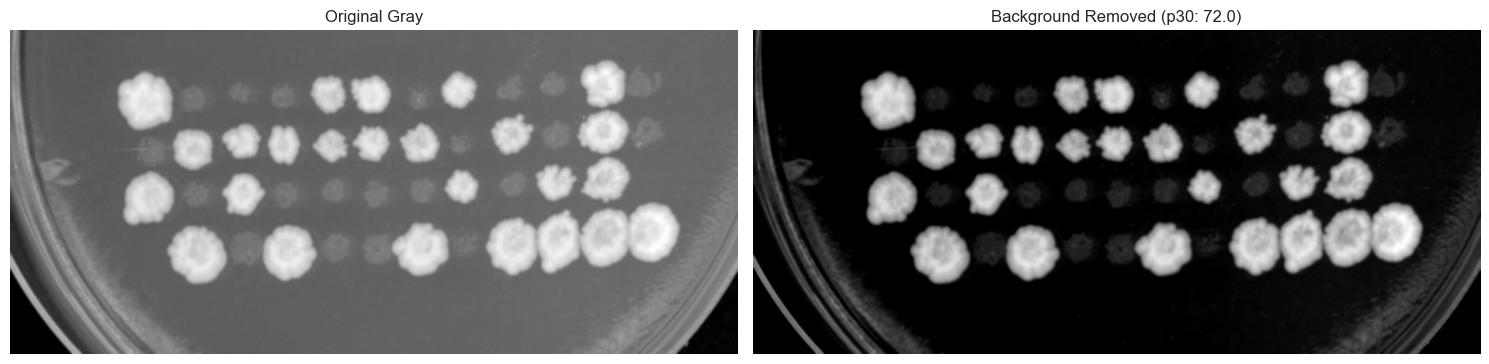

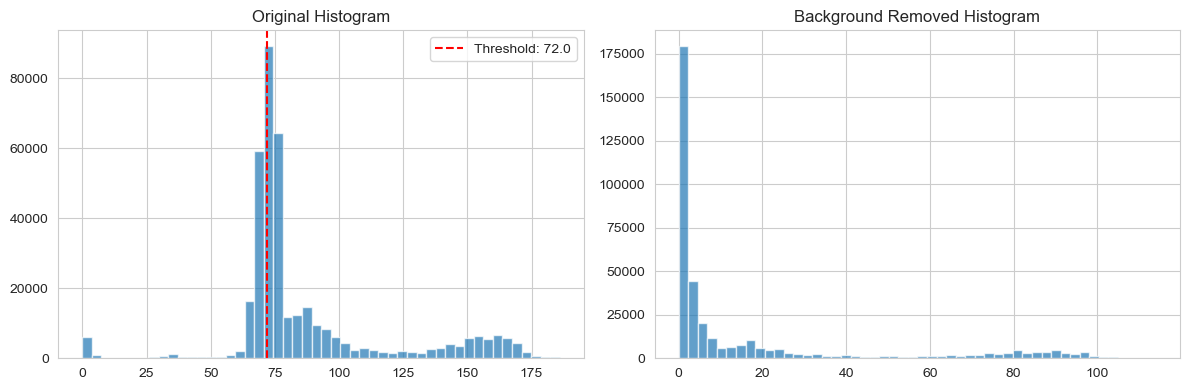

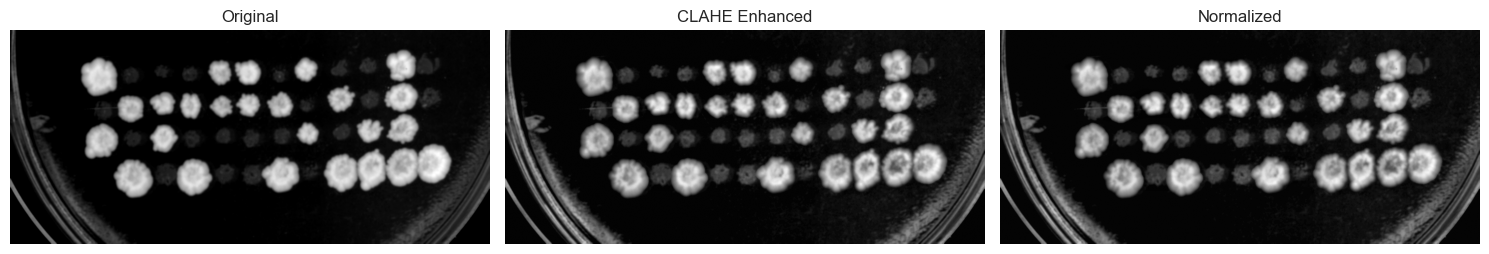

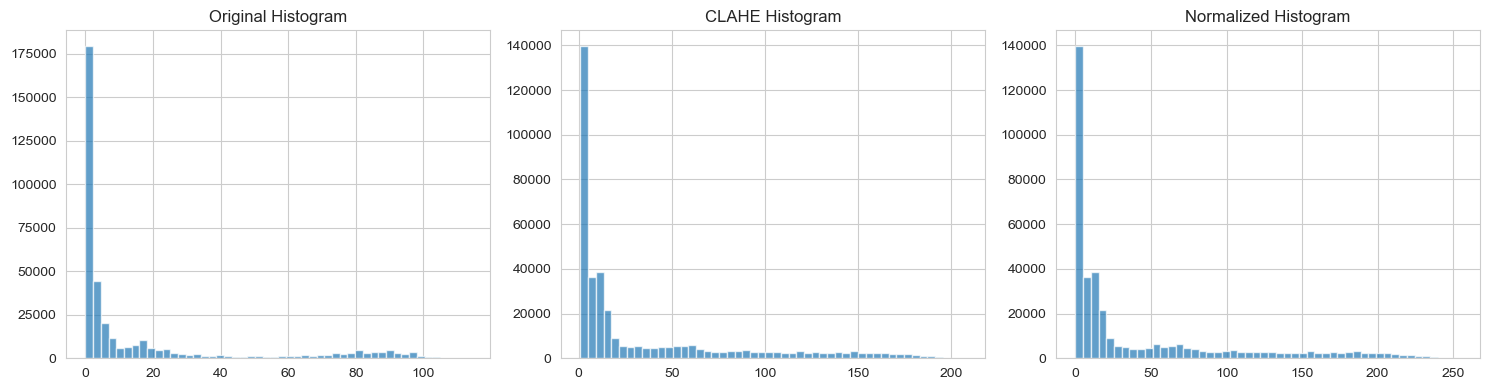


Preprocessing complete!


In [126]:
def remove_background(
    gray_image: np.ndarray,
    threshold_percentile: float = 25,
    visualize: bool = True
) -> np.ndarray:
    """Remove background using percentile-based thresholding."""
    # Calculate background threshold
    threshold_value = np.percentile(gray_image[gray_image > 0], threshold_percentile)
    
    # Subtract background
    bg_removed = cv2.subtract(gray_image, np.full_like(gray_image, threshold_value))
    bg_removed = np.clip(bg_removed, 0, 255).astype(np.uint8)
    
    if visualize:
        show_images(
            [gray_image, bg_removed],
            ['Original Gray', f'Background Removed (p{threshold_percentile}: {threshold_value:.1f})']
        )
        
        # Plot histograms
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.hist(gray_image.flatten(), bins=50, alpha=0.7)
        ax1.axvline(threshold_value, color='r', linestyle='--', label=f'Threshold: {threshold_value:.1f}')
        ax1.set_title('Original Histogram')
        ax1.legend()
        
        ax2.hist(bg_removed.flatten(), bins=50, alpha=0.7)
        ax2.set_title('Background Removed Histogram')
        plt.tight_layout()
        plt.show()
    
    return bg_removed

def enhance_contrast(
    gray_image: np.ndarray,
    clip_limit: float = 3.0,
    tile_grid_size: tuple = (15, 15),
    visualize: bool = True
) -> np.ndarray:
    """Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(gray_image)
    
    # Normalize to full range
    normalized = cv2.normalize(enhanced, dst=None, alpha=0, beta=255, 
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    if visualize:
        show_images(
            [gray_image, enhanced, normalized],
            ['Original', 'CLAHE Enhanced', 'Normalized']
        )
        
        # Show histogram comparison
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for i, (img, title) in enumerate([(gray_image, 'Original'), 
                                        (enhanced, 'CLAHE'), 
                                        (normalized, 'Normalized')]):
            axes[i].hist(img.flatten(), bins=50, alpha=0.7)
            axes[i].set_title(f'{title} Histogram')
        plt.tight_layout()
        plt.show()
    
    return normalized

# Test preprocessing with a sample plate
if 'plates' in locals() and plates:
    sample_plate = plates[1]
    
    # Convert to grayscale (use red channel for better colony contrast)
    gray = sample_plate[:, :, 2] if len(sample_plate.shape) == 3 else sample_plate

    h, w = gray.shape
    gray = gray[int(h*0.45):int(h*0.85), int(w*0.05):int(w*0.95)]  # Crop to central region
    
    print("Preprocessing steps:")
    print("1. Original grayscale image")
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    print("2. Gaussian blur applied")
    
    # Remove background
    bg_removed = remove_background(blurred, threshold_percentile=30, visualize=True)
    
    # Enhance contrast
    enhanced = enhance_contrast(bg_removed, clip_limit=3.0, visualize=True)
    
    print("\nPreprocessing complete!")

## Step 4: Image Binarization

Convert the preprocessed image to binary using adaptive thresholding or Otsu's method to separate colonies from background.

Testing binarization methods:

1. Tetrad-style (Otsu):


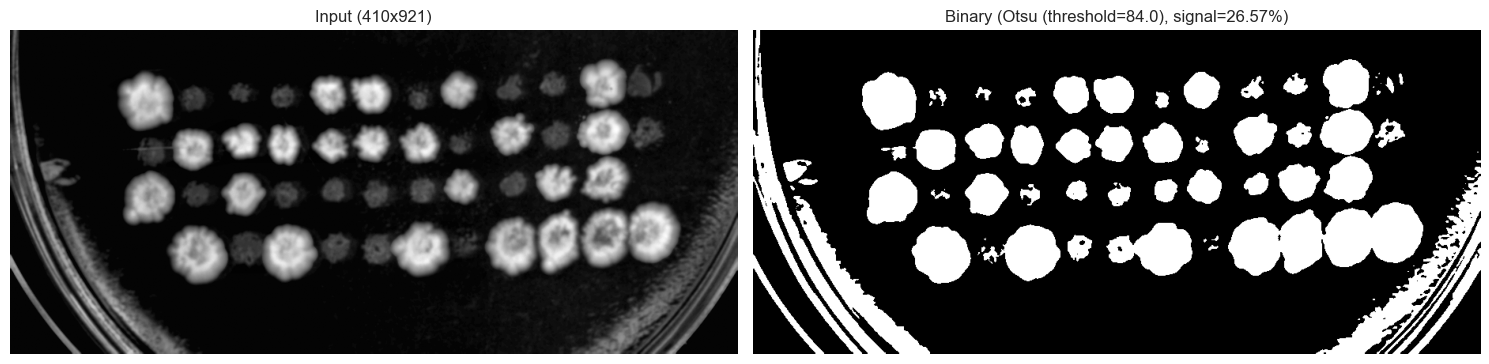

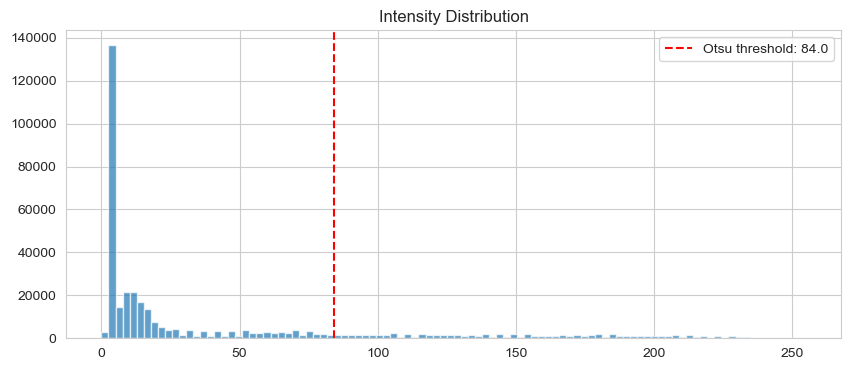

Signal ratio: 26.57% (pixels above threshold)

2. Replica-style (Adaptive):


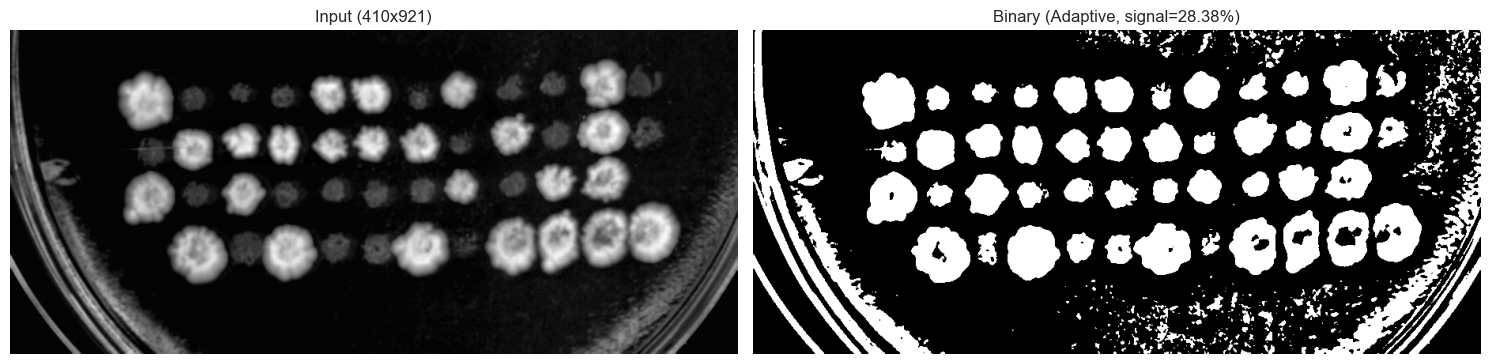

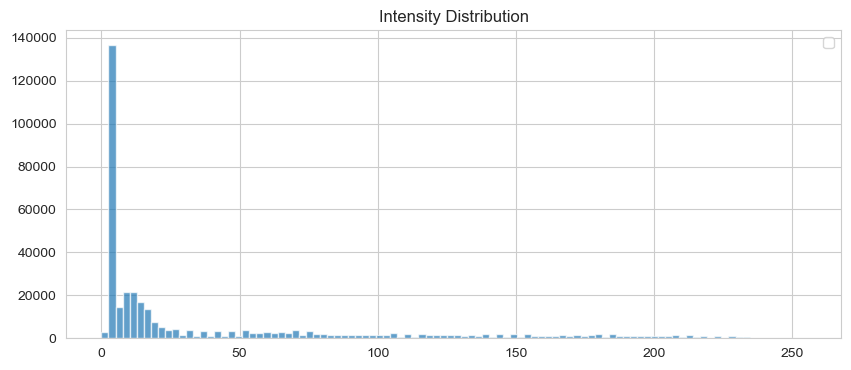

Signal ratio: 28.38% (pixels above threshold)


In [127]:
def binarize_image(
    gray_image: np.ndarray,
    replica: bool = False,
    visualize: bool = True
) -> tuple[np.ndarray, float]:
    """Binarize the grayscale image."""
    if replica:
        # Adaptive thresholding for replica images
        block_size = 201 if gray_image.shape[0] > 500 else 101
        thresh = cv2.adaptiveThreshold(
            gray_image,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            block_size,
            -2
        )
        method = "Adaptive"
    else:
        # Otsu's thresholding for tetrad images
        otsu_threshold, thresh = cv2.threshold(
            gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
        thresh = np.where(gray_image >= 0.7*otsu_threshold, 255, 0).astype(np.uint8)
        method = f"Otsu (threshold={otsu_threshold})"
    
    # Calculate signal ratio
    signal_ratio = np.sum(thresh > 0) / thresh.size
    
    if visualize:
        show_images(
            [gray_image, thresh],
            [f'Input ({gray_image.shape[0]}x{gray_image.shape[1]})', 
             f'Binary ({method}, signal={signal_ratio:.2%})']
        )
        
        # Show threshold value histogram
        plt.figure(figsize=(10, 4))
        plt.hist(gray_image.flatten(), bins=100, alpha=0.7)
        if not replica:
            plt.axvline(otsu_threshold, color='r', linestyle='--', 
                       label=f'Otsu threshold: {otsu_threshold}')
        plt.title('Intensity Distribution')
        plt.legend()
        plt.show()
        
        print(f"Signal ratio: {signal_ratio:.2%} (pixels above threshold)")
    
    return thresh, signal_ratio

# Test binarization
if 'enhanced' in locals():
    print("Testing binarization methods:")
    print("\n1. Tetrad-style (Otsu):")
    binary_tetrad, ratio_tetrad = binarize_image(enhanced, replica=False, visualize=True)
    
    print("\n2. Replica-style (Adaptive):")
    binary_replica, ratio_replica = binarize_image(enhanced, replica=True, visualize=True)

## Step 5: Morphological Processing

Apply morphological operations to clean up the binary image and fill holes in detected colonies.

Applying morphological operations:


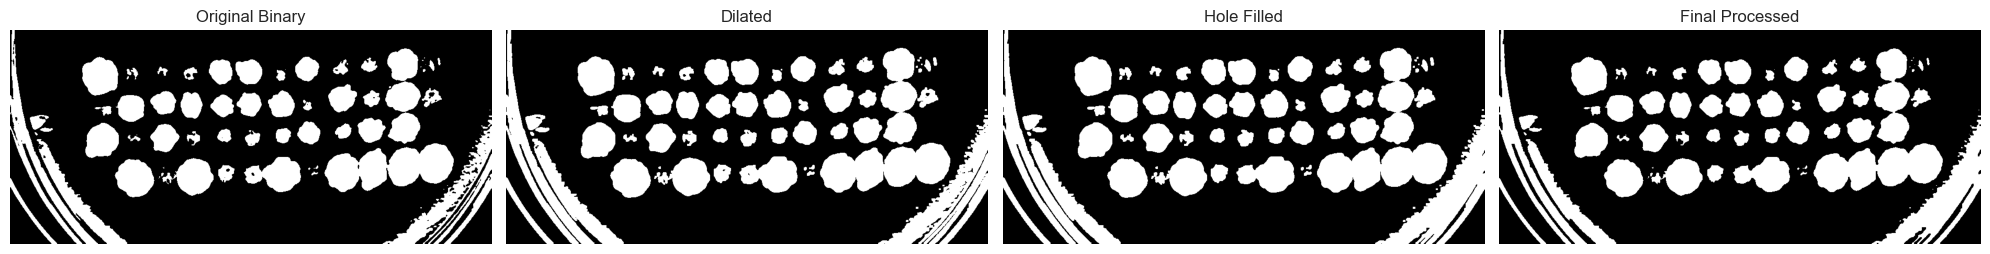

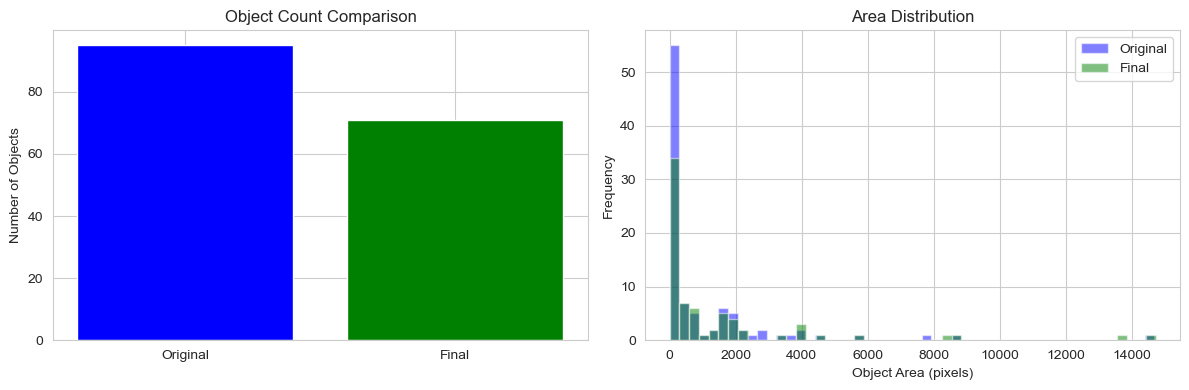

Objects: 95 → 71


In [128]:
def morphological_processing(
    binary_image: np.ndarray,
    visualize: bool = True
) -> np.ndarray:
    """Apply morphological operations to clean up the binary image."""
    kernel = np.ones((3, 3), np.uint8)
    
    # Apply dilation to merge nearby pixels
    dilated = cv2.morphologyEx(binary_image, cv2.MORPH_DILATE, kernel, iterations=1)
    
    # Fill holes in binary image
    thresh_hole_filled = np.array(ndimage.binary_fill_holes(dilated)).astype(np.uint8)
    
    # Apply erosion to restore boundaries
    eroded = cv2.morphologyEx(thresh_hole_filled, cv2.MORPH_ERODE, kernel, iterations=1)
    
    if visualize:
        show_images(
            [binary_image, dilated, thresh_hole_filled, eroded],
            ['Original Binary', 'Dilated', 'Hole Filled', 'Final Processed'],
            figsize=(20, 5)
        )
        
        # Show processing statistics
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Object count comparison
        from scipy.ndimage import label
        original_labels, original_count = label(binary_image > 0)
        final_labels, final_count = label(eroded > 0)
        
        objects = ['Original', 'Final']
        counts = [original_count, final_count]
        axes[0].bar(objects, counts, color=['blue', 'green'])
        axes[0].set_ylabel('Number of Objects')
        axes[0].set_title('Object Count Comparison')
        
        # Area distribution
        original_areas = [np.sum(original_labels == i) for i in range(1, original_count+1)]
        final_areas = [np.sum(final_labels == i) for i in range(1, final_count+1)]
        
        axes[1].hist(original_areas, bins=50, alpha=0.5, label='Original', color='blue')
        axes[1].hist(final_areas, bins=50, alpha=0.5, label='Final', color='green')
        axes[1].set_xlabel('Object Area (pixels)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Area Distribution')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Objects: {original_count} → {final_count}")
    
    return eroded

# Test morphological processing
if 'binary_tetrad' in locals():
    print("Applying morphological operations:")
    processed = morphological_processing(binary_tetrad, visualize=True)

## Step 6: Colony Detection using Watershed Segmentation

The watershed algorithm helps separate touching colonies that would otherwise be detected as a single large object.

Applying watershed segmentation:


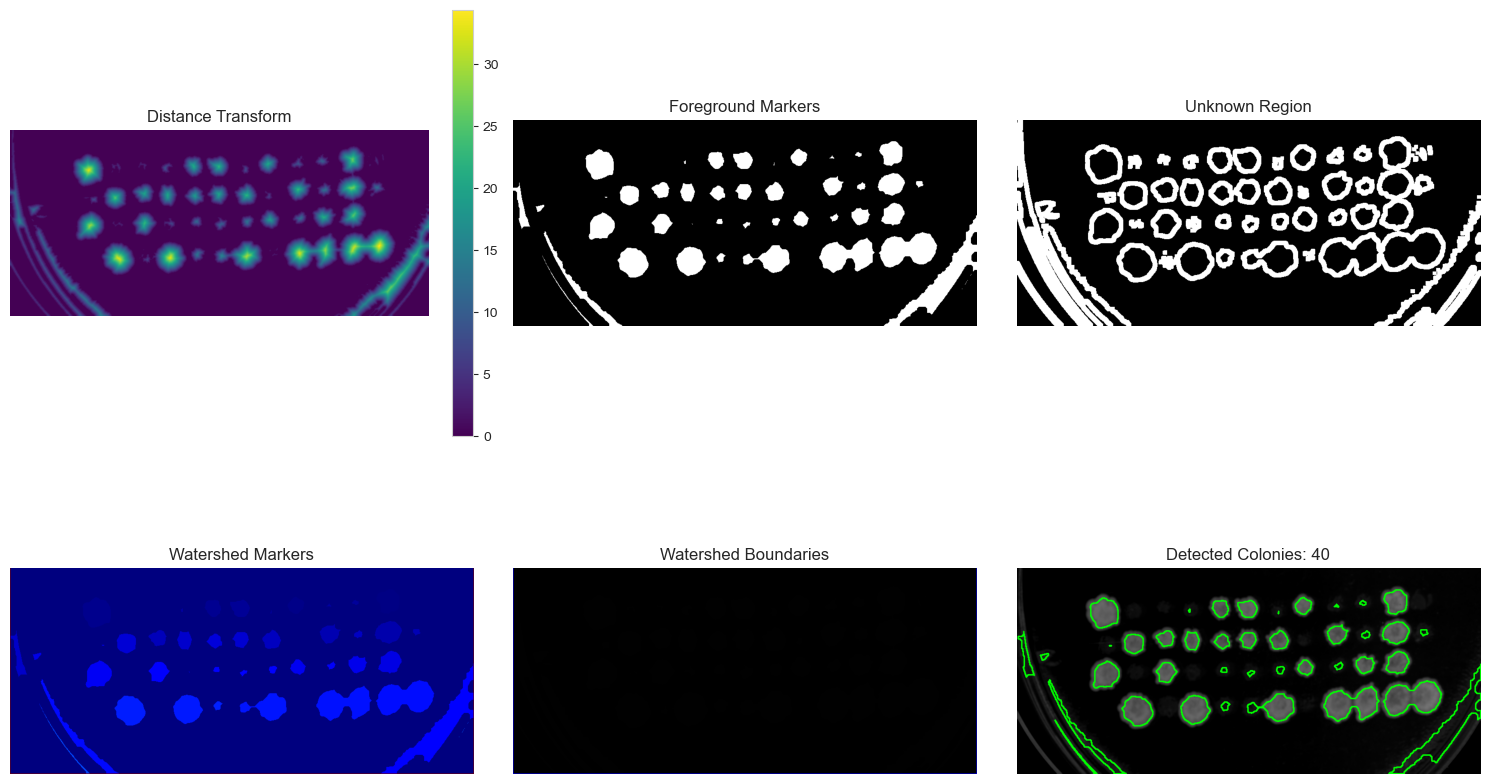

Watershed detected 40 colonies


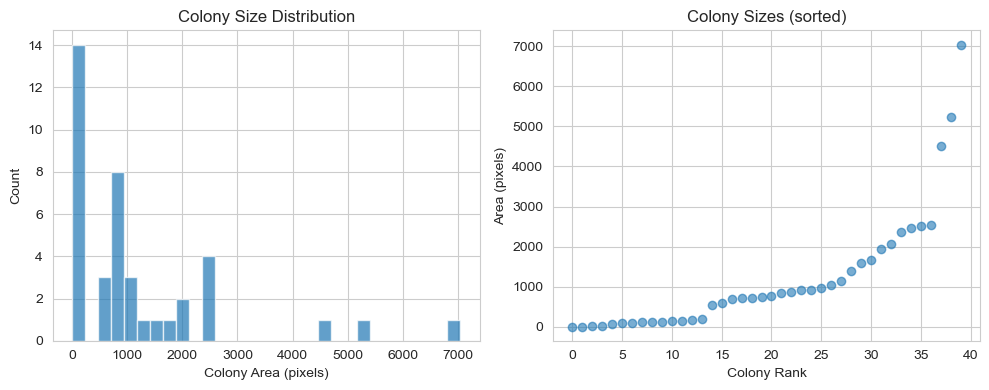

Area statistics: min=2, max=7044, mean=1201


In [129]:
def watershed_segmentation(
    gray_image: np.ndarray,
    binary_image: np.ndarray,
    watershed_threshold: float = 0.2,
    visualize: bool = True
) -> list[np.ndarray]:
    """Apply watershed segmentation to separate touching colonies."""
    # Distance transform
    dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
    
    # Find local maxima as markers
    _, sure_fg = cv2.threshold(
        dist_transform, 
        watershed_threshold * dist_transform.max(), 
        255, 0
    )
    sure_fg = np.uint8(sure_fg)
    
    # Find unknown region
    kernel_dilate = np.ones((3, 3), np.uint8)
    sure_bg = cv2.dilate(binary_image, kernel_dilate, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Label markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Add 1 so background is 1
    markers[unknown == 255] = 0  # Mark unknown region as 0
    
    # Apply watershed
    plate_bgr = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(plate_bgr, markers)
    
    # Extract contours from watershed labels
    contours = []
    
    for region_label in np.unique(markers):
        if region_label <= 1:  # Skip background and boundaries
            continue
        
        # Create binary mask for this region
        region_mask = (markers == region_label).astype(np.uint8) * 255
        
        # Smooth region boundaries
        kernel_smooth = np.ones((2, 2), np.uint8)
        region_mask = cv2.morphologyEx(region_mask, cv2.MORPH_CLOSE, kernel_smooth)
        
        # Find contours
        region_contours, _ = cv2.findContours(
            region_mask, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        # Add contours meeting minimum size
        for contour in region_contours:
            if cv2.contourArea(contour) > 1:
                contours.append(contour)
    
    if visualize:
        # Show watershed steps
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Step 1: Distance transform
        im1 = axes[0, 0].imshow(dist_transform, cmap='viridis')
        axes[0, 0].set_title('Distance Transform')
        plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)
        
        # Step 2: Foreground markers
        axes[0, 1].imshow(sure_fg, cmap='gray')
        axes[0, 1].set_title('Foreground Markers')
        
        # Step 3: Unknown region
        axes[0, 2].imshow(unknown, cmap='gray')
        axes[0, 2].set_title('Unknown Region')
        
        # Step 4: Markers visualization
        markers_viz = markers.copy()
        markers_viz[markers_viz == -1] = 255  # Watershed boundaries
        axes[1, 0].imshow(markers_viz, cmap='jet')
        axes[1, 0].set_title('Watershed Markers')
        
        # Step 5: Watershed result
        watershed_result = plate_bgr.copy()
        watershed_result[markers == -1] = [255, 0, 0]  # Red boundaries
        axes[1, 1].imshow(cv2.cvtColor(watershed_result, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title('Watershed Boundaries')
        
        # Step 6: Final contours
        contour_viz = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(contour_viz, contours, -1, (0, 255, 0), 2)
        axes[1, 2].imshow(cv2.cvtColor(contour_viz, cv2.COLOR_BGR2RGB))
        axes[1, 2].set_title(f'Detected Colonies: {len(contours)}')
        
        # Remove axis ticks
        for ax in axes.flat:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Watershed detected {len(contours)} colonies")
        
        # Analyze colony sizes
        areas = [cv2.contourArea(c) for c in contours]
        if areas:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.hist(areas, bins=30, alpha=0.7)
            plt.xlabel('Colony Area (pixels)')
            plt.ylabel('Count')
            plt.title('Colony Size Distribution')
            
            plt.subplot(1, 2, 2)
            plt.scatter(range(len(areas)), sorted(areas), alpha=0.6)
            plt.xlabel('Colony Rank')
            plt.ylabel('Area (pixels)')
            plt.title('Colony Sizes (sorted)')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Area statistics: min={min(areas):.0f}, max={max(areas):.0f}, mean={np.mean(areas):.0f}")
    
    return contours

# Test watershed segmentation
if 'processed' in locals():
    print("Applying watershed segmentation:")
    contours = watershed_segmentation(bg_removed, processed, watershed_threshold=0.2, visualize=True)

## Step 7: Filter Colonies by Quality Metrics

Filter detected colonies based on area, circularity, and solidity to remove noise and artifacts.

Filtering 40 detected colonies:
Configuration: min_size=50, circularity>0.7, solidity>0.9


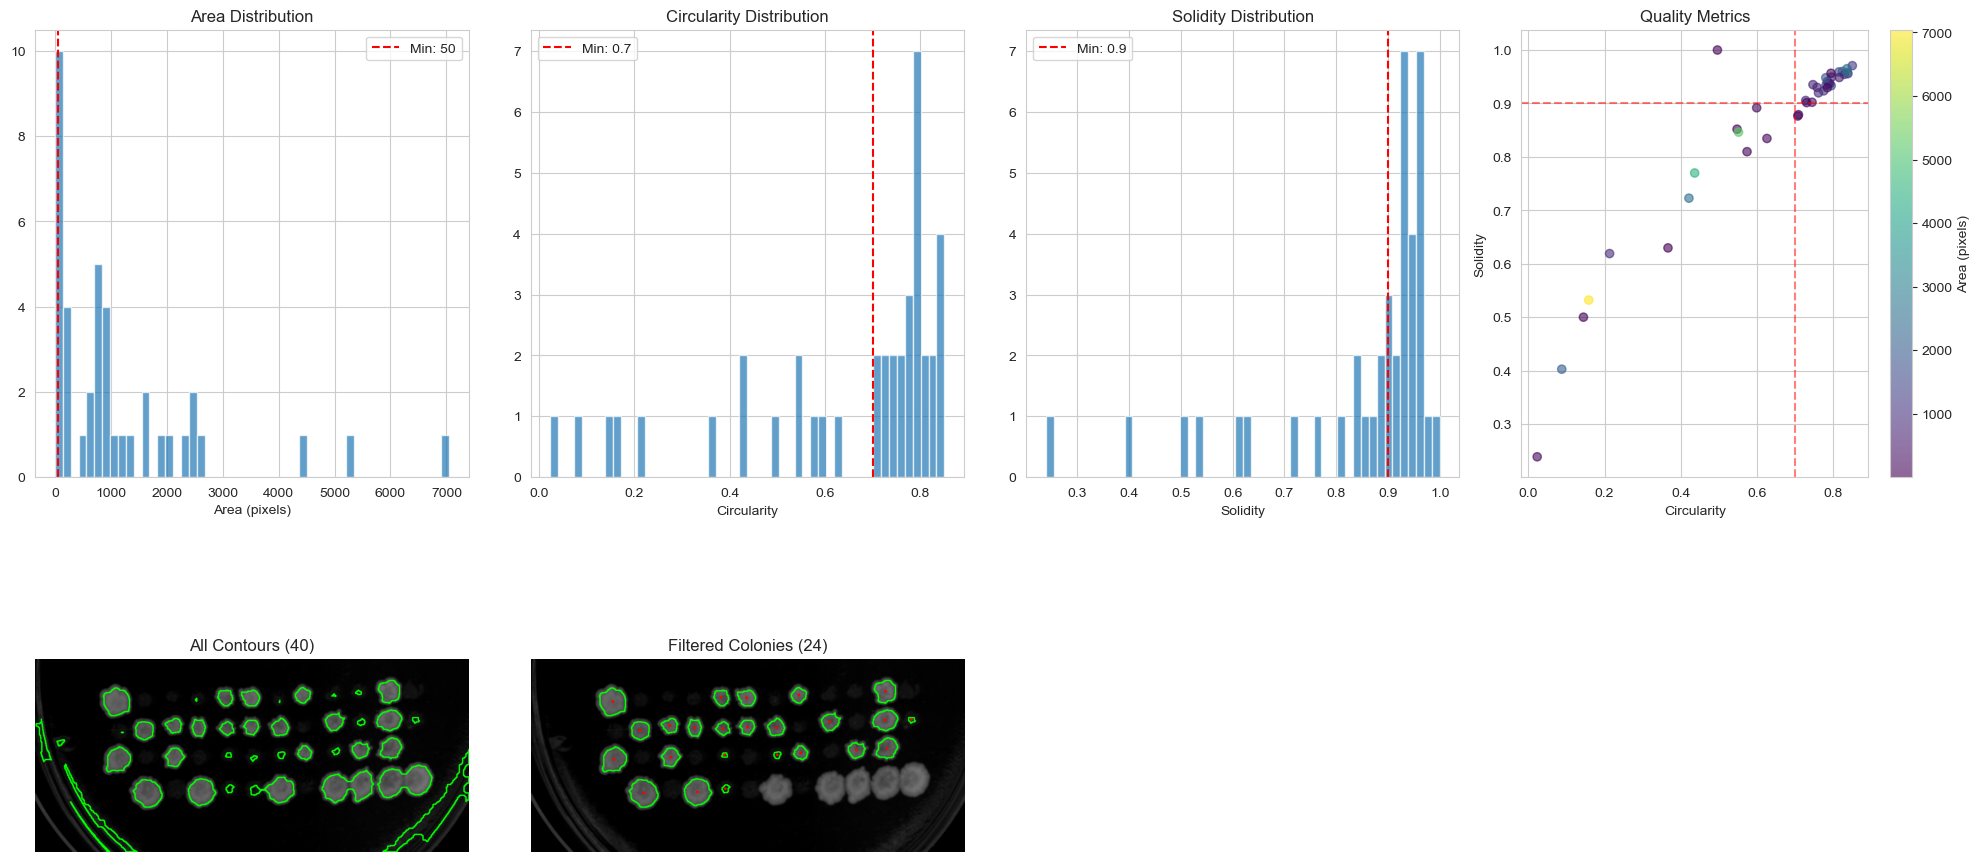


Filtered to 24 high-quality colonies


In [130]:
def filter_contours(
    contours: list[np.ndarray],
    plate_config: ImageProcessingConfig,
    visualize: bool = True
):
    """Filter contours based on quality metrics."""
    filtered_contours = []
    filtered_centroids = []
    metrics_data = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        if perimeter == 0:
            continue
        
        # Calculate shape metrics
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        
        circularity = (4 * np.pi * area) / (perimeter * perimeter)
        solidity = area / hull_area if hull_area > 0 else 0
        
        # Store metrics for analysis
        metrics_data.append({
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'solidity': solidity
        })
        
        # Apply filtering criteria
        if (area > plate_config.min_colony_size and 
            circularity > plate_config.circularity_threshold and 
            solidity > plate_config.solidity_threshold):
            filtered_contours.append(contour)
            
            # Calculate centroid
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
                filtered_centroids.append((cx, cy))
    
    if visualize:
        # Create visualizations for metrics
        fig_metrics = plt.figure(figsize=(20, 10))
        
        # Convert data to DataFrame for easier plotting
        df = pd.DataFrame(metrics_data)
        
        # Plot metrics distributions
        plt.subplot(2, 4, 1)
        plt.hist(df['area'], bins=50, alpha=0.7)
        plt.axvline(plate_config.min_colony_size, color='r', linestyle='--', 
               label=f'Min: {plate_config.min_colony_size}')
        plt.xlabel('Area (pixels)')
        plt.legend()
        plt.title('Area Distribution')
        
        plt.subplot(2, 4, 2)
        plt.hist(df['circularity'], bins=50, alpha=0.7)
        plt.axvline(plate_config.circularity_threshold, color='r', linestyle='--',
               label=f'Min: {plate_config.circularity_threshold}')
        plt.xlabel('Circularity')
        plt.legend()
        plt.title('Circularity Distribution')
        
        plt.subplot(2, 4, 3)
        plt.hist(df['solidity'], bins=50, alpha=0.7)
        plt.axvline(plate_config.solidity_threshold, color='r', linestyle='--',
               label=f'Min: {plate_config.solidity_threshold}')
        plt.xlabel('Solidity')
        plt.legend()
        plt.title('Solidity Distribution')
        
        # Scatter plot of metrics
        plt.subplot(2, 4, 4)
        scatter = plt.scatter(df['circularity'], df['solidity'], 
                   c=df['area'], cmap='viridis', alpha=0.6)
        plt.axvline(plate_config.circularity_threshold, color='r', linestyle='--', alpha=0.5)
        plt.axhline(plate_config.solidity_threshold, color='r', linestyle='--', alpha=0.5)
        plt.xlabel('Circularity')
        plt.ylabel('Solidity')
        plt.title('Quality Metrics')
        plt.colorbar(scatter, label='Area (pixels)')
        
        # Show filtered vs original contours
        viz_gray = bg_removed if 'bg_removed' in locals() else np.zeros((500, 500), dtype=np.uint8)
        
        plt.subplot(2, 4, 5)
        viz_original = cv2.cvtColor(bg_removed, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(viz_original, contours, -1, (0, 255, 0), 2)
        plt.imshow(viz_original)
        plt.title(f'All Contours ({len(contours)})')
        plt.axis('off')

        # Filtered contours
        plt.subplot(2, 4, 6)
        viz_filtered = cv2.cvtColor(bg_removed, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(viz_filtered, filtered_contours, -1, (0, 255, 0), 2)
        for cx, cy in filtered_centroids:
            cv2.circle(viz_filtered, (cx, cy), 3, (255, 0, 0), -1)
        plt.imshow(viz_filtered)
        plt.title(f'Filtered Colonies ({len(filtered_contours)})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
            
    return filtered_contours, filtered_centroids

# Test contour filtering
if 'contours' in locals():
    print(f"Filtering {len(contours)} detected colonies:")
    print(f"Configuration: min_size={tetrad_config.min_colony_size}, "
          f"circularity>{tetrad_config.circularity_threshold}, "
          f"solidity>{tetrad_config.solidity_threshold}")
    
    filtered_contours, filtered_centroids = filter_contours(
        contours, tetrad_config, visualize=True
    )
    
    print(f"\nFiltered to {len(filtered_contours)} high-quality colonies")

## Step 8: Calculate Plate Centroid

Calculate the centroid of all detected colonies, which will be used for the final cropping.

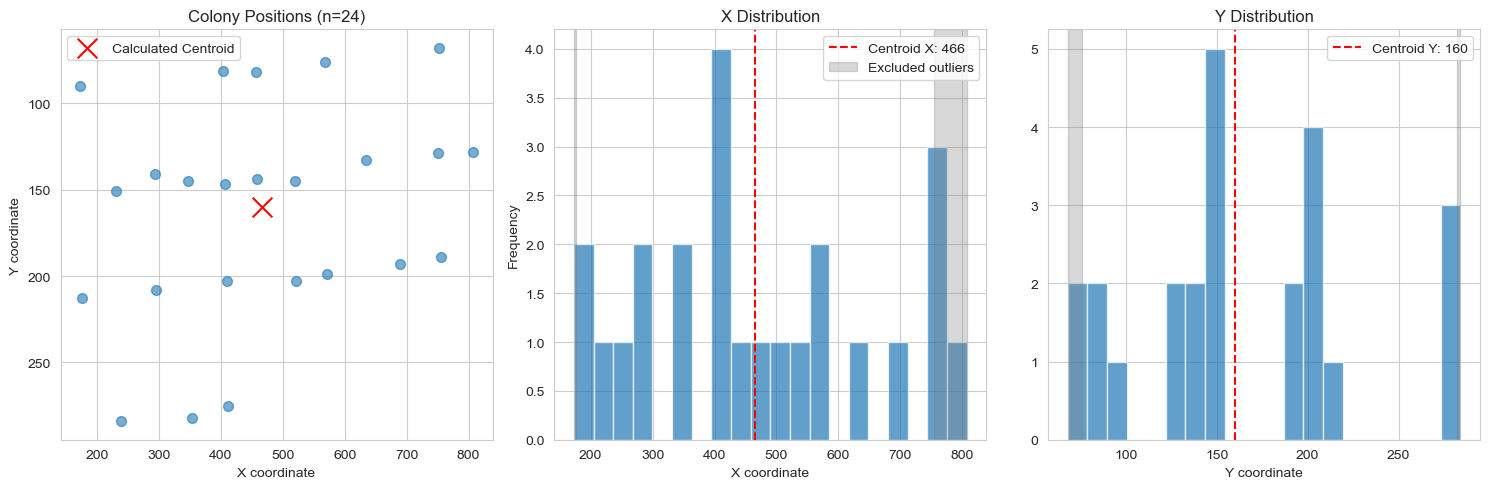

Calculated centroid: (466, 160)
Excluded 2 outliers from each end


In [131]:
def calculate_centroids(
    gray: np.ndarray,
    colony_centroids: list[tuple[int, int]],
    visualize: bool = True
) -> tuple[int, int]:
    """Calculate the centroid of all colonies."""
    if colony_centroids:
        # Sort coordinates
        x_coords = sorted([p[0] for p in colony_centroids])
        y_coords = sorted([p[1] for p in colony_centroids])
        
        # Calculate centroid with outlier removal
        if len(colony_centroids) > 14:
            # Exclude extreme outliers
            centroid_x = int(np.round(np.mean(x_coords[2:-2])))
            centroid_y = int(np.round(np.mean(y_coords[2:-2])))
            excluded = 2
        elif len(colony_centroids) > 7:
            centroid_x = int(np.round(np.mean(x_coords[1:-1])))
            centroid_y = int(np.round(np.mean(y_coords[1:-1])))
            excluded = 1
        else:
            centroid_x = int(np.round(np.mean(x_coords)))
            centroid_y = int(np.round(np.mean(y_coords)))
            excluded = 0
            print("Warning: Few colonies detected, using all points")
    else:
        # Fallback to image center
        centroid_x, centroid_y = gray.shape[1] // 2, gray.shape[0] // 2
        excluded = None
    
    if visualize and colony_centroids:
        # Visualize centroid calculation
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot 1: All colony positions
        axes[0].scatter([p[0] for p in colony_centroids], 
                       [p[1] for p in colony_centroids], 
                       alpha=0.6, s=50)
        axes[0].scatter(centroid_x, centroid_y, color='red', s=200, 
                      marker='x', label='Calculated Centroid')
        axes[0].set_xlabel('X coordinate')
        axes[0].set_ylabel('Y coordinate')
        axes[0].set_title(f'Colony Positions (n={len(colony_centroids)})')
        axes[0].legend()
        axes[0].invert_yaxis()
        
        # Plot 2: X coordinate distribution
        axes[1].hist(x_coords, bins=20, alpha=0.7)
        axes[1].axvline(centroid_x, color='red', linestyle='--', 
                      label=f'Centroid X: {centroid_x}')
        if excluded:
            axes[1].axvspan(x_coords[0], x_coords[excluded-1], alpha=0.3, color='gray',
                          label='Excluded outliers')
            axes[1].axvspan(x_coords[-excluded], x_coords[-1], alpha=0.3, color='gray')
        axes[1].set_xlabel('X coordinate')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('X Distribution')
        axes[1].legend()
        
        # Plot 3: Y coordinate distribution
        axes[2].hist(y_coords, bins=20, alpha=0.7)
        axes[2].axvline(centroid_y, color='red', linestyle='--',
                      label=f'Centroid Y: {centroid_y}')
        if excluded:
            axes[2].axvspan(y_coords[0], y_coords[excluded-1], alpha=0.3, color='gray')
            axes[2].axvspan(y_coords[-excluded], y_coords[-1], alpha=0.3, color='gray')
        axes[2].set_xlabel('Y coordinate')
        axes[2].set_title('Y Distribution')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Calculated centroid: ({centroid_x}, {centroid_y})")
        if excluded:
            print(f"Excluded {excluded} outliers from each end")
    
    return centroid_x, centroid_y

# Test centroid calculation
if 'filtered_centroids' in locals():
    centroid_x, centroid_y = calculate_centroids(
        processed if 'processed' in locals() else np.zeros((500, 500), dtype=np.uint8),
        filtered_centroids,
        visualize=True
    )

## Step 9: Final Cropping

Crop the plate around the calculated centroid to create a standardized output image.

Performing final crop:


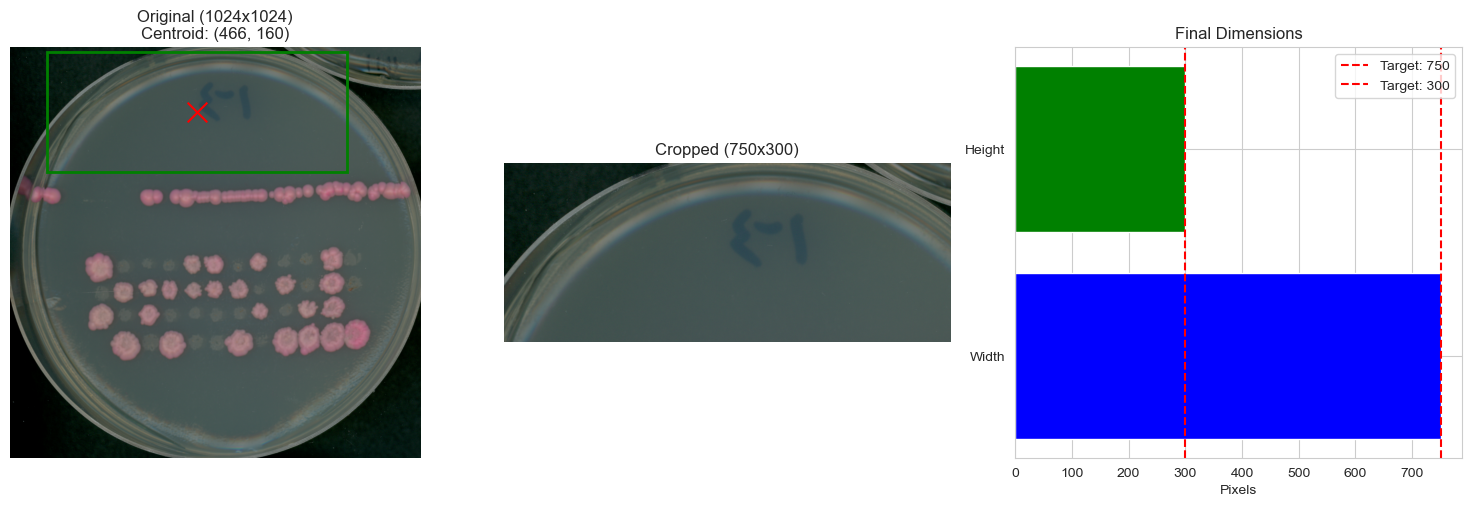

Final crop size: 750x300
Target size: 750x300


In [132]:
def final_crop(
    plate_image: np.ndarray,
    centroid_x: int,
    centroid_y: int,
    final_width: int = 750,
    final_height: int = 300,
    visualize: bool = True
) -> np.ndarray:
    """Perform final cropping around the centroid."""
    h, w = plate_image.shape[:2]
    
    # Calculate crop boundaries
    start_x = max(0, centroid_x - final_width // 2)
    end_x = min(w, centroid_x + final_width // 2)
    start_y = max(0, centroid_y - final_height // 2)
    end_y = min(h, centroid_y + final_height // 2)
    
    # Crop the image
    cropped = plate_image[start_y:end_y, start_x:end_x]
    
    if visualize:
        # Show cropping process
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original with centroid
        axes[0].imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
        axes[0].scatter(centroid_x, centroid_y, color='red', s=200, marker='x')
        rect = plt.Rectangle((start_x, start_y), end_x-start_x, end_y-start_y, 
                           fill=False, edgecolor='green', linewidth=2)
        axes[0].add_patch(rect)
        axes[0].set_title(f'Original ({w}x{h})\nCentroid: ({centroid_x}, {centroid_y})')
        axes[0].axis('off')
        
        # Cropped region
        axes[1].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Cropped ({cropped.shape[1]}x{cropped.shape[0]})')
        axes[1].axis('off')
        
        # Crop dimensions visualization
        axes[2].barh(['Width', 'Height'], [cropped.shape[1], cropped.shape[0]], 
                   color=['blue', 'green'])
        axes[2].axvline(final_width, color='red', linestyle='--', label=f'Target: {final_width}')
        axes[2].axvline(final_height, color='red', linestyle='--', label=f'Target: {final_height}')
        axes[2].set_xlabel('Pixels')
        axes[2].set_title('Final Dimensions')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Final crop size: {cropped.shape[1]}x{cropped.shape[0]}")
        print(f"Target size: {final_width}x{final_height}")
    
    return cropped

# Test final cropping
if 'sample_plate' in locals():
    print("Performing final crop:")
    final_cropped = final_crop(
        sample_plate,
        centroid_x,
        centroid_y,
        final_width=tetrad_config.final_width,
        final_height=tetrad_config.final_height,
        visualize=True
    )

## Complete Pipeline Demonstration

Let's put everything together and run the complete pipeline on a sample image:

In [ ]:
def process_single_plate(
    plate_image: np.ndarray,
    plate_config: ImageProcessingConfig,
    replica: bool = False,
    visualize: bool = True
) -> dict:
    """Process a single plate image through the complete pipeline."""
    # Step 1: Convert to grayscale (use red channel)
    gray = plate_image[:, :, 2] if len(plate_image.shape) == 3 else plate_image
    h, w = gray.shape[:2]
    
    # Step 2: Crop to specified height and width ranges
    start_h, end_h = int(h * plate_config.height_range[0] / 100), int(h * plate_config.height_range[1] / 100)
    start_w, end_w = int(w * plate_config.width_range[0] / 100), int(w * plate_config.width_range[1] / 100)
    gray = gray[start_h:end_h, start_w:end_w]
    
    # Step 3: Preprocessing
    if replica:
        gray = cv2.GaussianBlur(gray, (9, 9), 0)
        gray = remove_background(gray, threshold_percentile=50, visualize=False)
    else:
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        gray = remove_background(gray, threshold_percentile=30, visualize=False)
    
    # Step 4: Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(15, 15))
    enhanced = clahe.apply(gray)
    normalized = cv2.normalize(enhanced, dst=None, alpha=0, beta=255, 
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Step 5: Binarization
    thresh, signal_ratio = binarize_image(normalized, replica=replica, visualize=False)
    
    # Step 6: Morphological operations
    processed = morphological_processing(thresh, visualize=False)
    
    # Step 7: Colony detection
    contours = watershed_segmentation(gray, processed, watershed_threshold=0.3, visualize=False)
    
    # Step 8: Filter colonies
    filtered_contours, colony_centroids = filter_contours(contours, plate_config, visualize=False)
    
    # Step 9: Calculate centroid
    tetrad_centroid = calculate_centroids(processed, colony_centroids, visualize=False)
    centroid_x, centroid_y = tetrad_centroid
    centroid_x += start_w
    centroid_y += start_h
    
    # Step 10: Create visualization
    viz_image = None
    if plate_config.visualize_colonies:
        viz_image = cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR)
        for contour in filtered_contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
                cv2.drawContours(viz_image, [contour], -1, (0, 255, 0), 2)
                cv2.circle(viz_image, (cx, cy), 5, (0, 0, 255), -1)
        cv2.rectangle(viz_image, (centroid_x-start_w-10, centroid_y-start_h-10), 
                     (centroid_x-start_w+10, centroid_y-start_h+10), (0, 0, 255), -1)
    
    # Step 11: Final cropping
    final_width = plate_config.final_width
    final_height = plate_config.final_height
    start_x = max(0, centroid_x - final_width // 2)
    end_x = start_x + final_width
    start_y = max(0, centroid_y - final_height // 2)
    end_y = start_y + final_height
    cropped = plate_image[start_y:end_y, start_x:end_x]
    
    return {
        'centroid': (centroid_x, centroid_y),
        'viz_image': viz_image,
        'colony_centroids': colony_centroids,
        'num_colonies': len(filtered_contours),
        'final_cropped': cropped,
        'signal_ratio': signal_ratio
    }

# Run complete pipeline
if 'sample_plate' in locals():
    print("Running complete pipeline:")
    result = process_single_plate(sample_plate, tetrad_config, replica=False, visualize=True)
    
    # Show final results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(sample_plate, cv2.COLOR_BGR2RGB))
    plt.title('Original Plate')
    plt.axis('off')
    
    if result['viz_image'] is not None:
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(result['viz_image'], cv2.COLOR_BGR2RGB))
        plt.title(f"Detected {result['num_colonies']} colonies")
        plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result['final_cropped'], cv2.COLOR_BGR2RGB))
    plt.title('Final Cropped Output')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPipeline Results:")
    print(f"- Detected colonies: {result['num_colonies']}")
    print(f"- Centroid: {result['centroid']}")
    print(f"- Signal ratio: {result['signal_ratio']:.2%}")
    print(f"- Output size: {result['final_cropped'].shape[1]}x{result['final_cropped'].shape[0]}")

## Processing Multiple Plates

The pipeline includes centroid adjustment across multiple plates to ensure consistent alignment. Here's how it works:

In [ ]:
def process_multiple_plates(
    plate_images: list[np.ndarray],
    plate_config: ImageProcessingConfig,
    replica: bool = False,
    visualize: bool = True
) -> list[dict]:
    """Process multiple plates with centroid adjustment."""
    processed_plates = []
    
    # Process each plate individually first
    for i, plate_image in enumerate(plate_images):
        result = process_single_plate(plate_image, plate_config, replica=replica, visualize=False)
        result['plate_index'] = i
        processed_plates.append(result)
    
    # Centroid adjustment across plates
    if plate_config.max_centroid_deviation_px is not None:
        # Calculate average centroid
        centroids = np.array([p['centroid'] for p in processed_plates])
        avg_centroid = np.mean(centroids, axis=0)
        
        if visualize:
            print(f"Average centroid across {len(processed_plates)} plates: {tuple(avg_centroid.astype(int))}")
            
            # Visualize centroid distribution
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.scatter(centroids[:, 0], centroids[:, 1], s=100, alpha=0.6)
            plt.scatter(avg_centroid[0], avg_centroid[1], s=200, marker='x', color='red', 
                      label='Average Centroid')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            plt.title('Centroid Distribution')
            plt.legend()
            plt.axis('equal')
            
            # Plot deviations
            plt.subplot(1, 2, 2)
            deviations = [np.linalg.norm(c - avg_centroid) for c in centroids]
            colors = ['green' if d <= plate_config.normal_centroid_deviation_px else 
                     'orange' if d <= plate_config.max_centroid_deviation_px else 'red' 
                     for d in deviations]
            plt.bar(range(len(deviations)), deviations, color=colors)
            plt.axhline(plate_config.normal_centroid_deviation_px, color='blue', linestyle='--',
                      label='Normal threshold')
            plt.axhline(plate_config.max_centroid_deviation_px, color='red', linestyle='--',
                      label='Max threshold')
            plt.xlabel('Plate Index')
            plt.ylabel('Deviation (pixels)')
            plt.title('Centroid Deviations')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
        
        # Adjust centroids if needed
        for p in processed_plates:
            dist = np.linalg.norm(np.array(p['centroid']) - avg_centroid)
            if dist > plate_config.max_centroid_deviation_px:
                print(f"Warning: Large deviation {dist:.1f}px for plate {p['plate_index']}")
                p['final_centroid'] = tuple(avg_centroid.astype(int))
            elif dist > plate_config.normal_centroid_deviation_px:
                # Gradual adjustment
                new_centroid = (np.array(p['centroid']) + avg_centroid) / 2
                p['final_centroid'] = tuple(new_centroid.astype(int))
            else:
                p['final_centroid'] = p['centroid']
            
            # Re-crop with adjusted centroid
            centroid_x, centroid_y = p['final_centroid']
            final_width = plate_config.final_width
            final_height = plate_config.final_height
            start_x = max(0, centroid_x - final_width // 2)
            end_x = start_x + final_width
            start_y = max(0, centroid_y - final_height // 2)
            end_y = start_y + final_height
            cropped = plate_images[p['plate_index']][start_y:end_y, start_x:end_x]
            p['final_cropped'] = cropped
    
    return processed_plates

# Test with multiple plates (if available)
if 'plates' in locals() and len(plates) > 1:
    print(f"Processing {len(plates)} plates with centroid adjustment:")
    results = process_multiple_plates(
        plates[:3],  # Process first 3 plates for demonstration
        tetrad_config,
        replica=False,
        visualize=True
    )
    
    # Show results
    plt.figure(figsize=(15, 5))
    for i, result in enumerate(results):
        plt.subplot(1, len(results), i+1)
        plt.imshow(cv2.cvtColor(result['final_cropped'], cv2.COLOR_BGR2RGB))
        plt.title(f"Plate {i+1}\n{result['num_colonies']} colonies")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Need multiple plates to demonstrate centroid adjustment")

## Summary

This tutorial has walked through the complete image processing pipeline for yeast colony detection and plate cropping. Key points:

### Pipeline Steps:
1. **Circle Detection**: Hough circle transform identifies plate boundaries
2. **Plate Cropping**: Extract individual plates from the image
3. **Preprocessing**: Remove background, enhance contrast with CLAHE
4. **Binarization**: Convert to binary using Otsu or adaptive thresholding
5. **Morphological Operations**: Clean up binary image and fill holes
6. **Colony Detection**: Watershed segmentation separates touching colonies
7. **Filtering**: Quality control based on area, circularity, and solidity
8. **Centroid Calculation**: Determine plate center for final cropping
9. **Final Cropping**: Create standardized output images

### Key Parameters:
- **Tetrad plates**: Smaller colonies (50px min), high circularity (0.7), high solidity (0.9)
- **Replica plates**: Larger colonies (500px min), lower circularity (0.45), lower solidity (0.7)
- **Adaptive block size**: 30 for tetrads, 200 for replicas
- **Contrast**: 1.0 for tetrads, 1.6 for replicas

The pipeline is designed to be robust to variations in illumination, colony size, and plate positioning while maintaining consistent output dimensions for downstream analysis.